# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [696]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [697]:
websites = pd.read_csv('../data/website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [698]:
# Your code here

## What the dataset looks like?
websites.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [699]:
## What are the data types?

websites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1781 non-null   object 
 1   URL_LENGTH                 1781 non-null   int64  
 2   NUMBER_SPECIAL_CHARACTERS  1781 non-null   int64  
 3   CHARSET                    1781 non-null   object 
 4   SERVER                     1780 non-null   object 
 5   CONTENT_LENGTH             969 non-null    float64
 6   WHOIS_COUNTRY              1781 non-null   object 
 7   WHOIS_STATEPRO             1781 non-null   object 
 8   WHOIS_REGDATE              1781 non-null   object 
 9   WHOIS_UPDATED_DATE         1781 non-null   object 
 10  TCP_CONVERSATION_EXCHANGE  1781 non-null   int64  
 11  DIST_REMOTE_TCP_PORT       1781 non-null   int64  
 12  REMOTE_IPS                 1781 non-null   int64  
 13  APP_BYTES                  1781 non-null   int64

In [700]:
## Which columns contain the features of the websites?



In [701]:
## Which column contains the feature we will predict? 

## What is the code standing for benign vs malicious websites?

#Variable type, where 1 = malicious, and 0 = benign

In [702]:
## Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

# No, all categorical variables seem to be correctly identified. Just maybe might be worth to transform the date columns into date variables.

In [703]:
# Your comment here


#### Next, evaluate if the columns in this dataset are strongly correlated.

If our dataset has strongly correlated columns, we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [704]:
# Your code here

websites.corr()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.917986,0.129745,-0.038407,-0.039839,-0.046367,-0.026446,-0.042264,-0.033779,-0.014857,-0.026686,-0.042264,-0.068582,0.162104
NUMBER_SPECIAL_CHARACTERS,0.917986,1.000000,0.214225,-0.037459,-0.042619,-0.047103,-0.023914,-0.040096,-0.030597,-0.014376,-0.024098,-0.040096,-0.050048,0.280897
CONTENT_LENGTH,0.129745,0.214225,1.000000,0.078451,-0.000381,0.004774,0.051202,0.074142,0.091077,0.100094,0.047595,0.074142,-0.045644,-0.090852
TCP_CONVERSATION_EXCHANGE,-0.038407,-0.037459,0.078451,1.000000,0.555188,0.331080,0.457320,0.997796,0.990848,0.865580,0.458702,0.997796,0.349832,-0.040202
DIST_REMOTE_TCP_PORT,-0.039839,-0.042619,-0.000381,0.555188,1.000000,0.210188,0.780238,0.558612,0.591188,0.313359,0.781212,0.558612,0.259942,-0.082925
REMOTE_IPS,-0.046367,-0.047103,0.004774,0.331080,0.210188,1.000000,0.023126,0.361104,0.304683,0.171651,0.025324,0.361104,0.548189,-0.078783
APP_BYTES,-0.026446,-0.023914,0.051202,0.457320,0.780238,0.023126,1.000000,0.445822,0.468999,0.074464,0.999992,0.445822,0.012221,-0.011262
SOURCE_APP_PACKETS,-0.042264,-0.040096,0.074142,0.997796,0.558612,0.361104,0.445822,1.000000,0.989285,0.857495,0.447448,1.000000,0.410843,-0.034414
REMOTE_APP_PACKETS,-0.033779,-0.030597,0.091077,0.990848,0.591188,0.304683,0.468999,0.989285,1.000000,0.880555,0.470401,0.989285,0.355716,-0.032897
SOURCE_APP_BYTES,-0.014857,-0.014376,0.100094,0.865580,0.313359,0.171651,0.074464,0.857495,0.880555,1.000000,0.075328,0.857495,0.215285,-0.043852


C:\Users\migue\AppData\Local\Temp\ipykernel_4380\4121991019.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


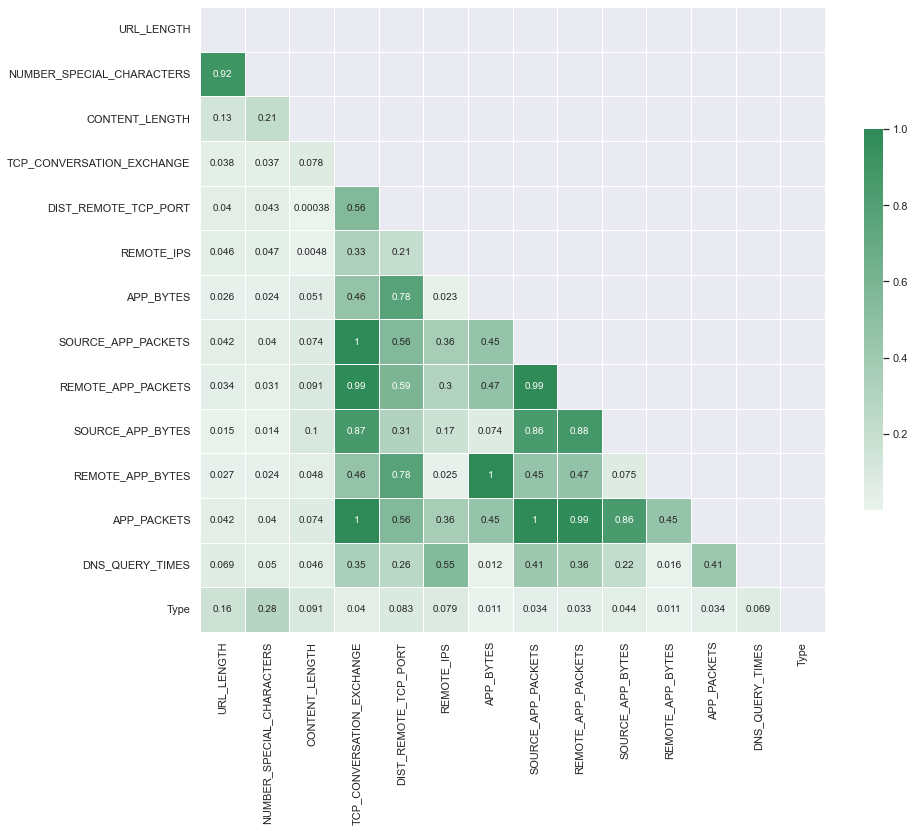

In [705]:
import seaborn as sns
import matplotlib.pyplot as plt

corr=np.abs(websites.corr())

#Set up mask for triangle representation - give only half of the trianlge
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))

# Generate a custom colormap
cmap = sns.light_palette("seagreen", as_cmap=True) 

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap = cmap,vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
plt.show()

In [706]:
# Your comment here

#source app packets, app_packets have higher collinearlity with TCP conversation exchange
#source app packets, app_packets have higher collinearlity with remote app packets
#remote bytes and app bytes have also higher collinearlity
#number of special characters with url length

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [707]:
# Your code here

##First i will remove number of special characters as it is higher correlated with url lenght, 
# and perhaps i am more interested to know how long an url is than to know how many special characters it contains:

websites.drop(columns = ["NUMBER_SPECIAL_CHARACTERS"], inplace = True)

## Second, i will remove APP_PACKETS since it's one of the variables that is more correlated with other varirables

websites.drop(columns = ["APP_PACKETS"], inplace = True)

## Third, applying the same reason again, I will now choose to remove TCP conversation exchange (a risk as i don't know what it means...)

websites.drop(columns = ["TCP_CONVERSATION_EXCHANGE"], inplace = True)

In [708]:
# Your comment here

# I still ended up with two pairs of variable highly correlated:
# app bytes vs remote app bytes
# remote app packets vs source app packets

C:\Users\migue\AppData\Local\Temp\ipykernel_4380\1182343046.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


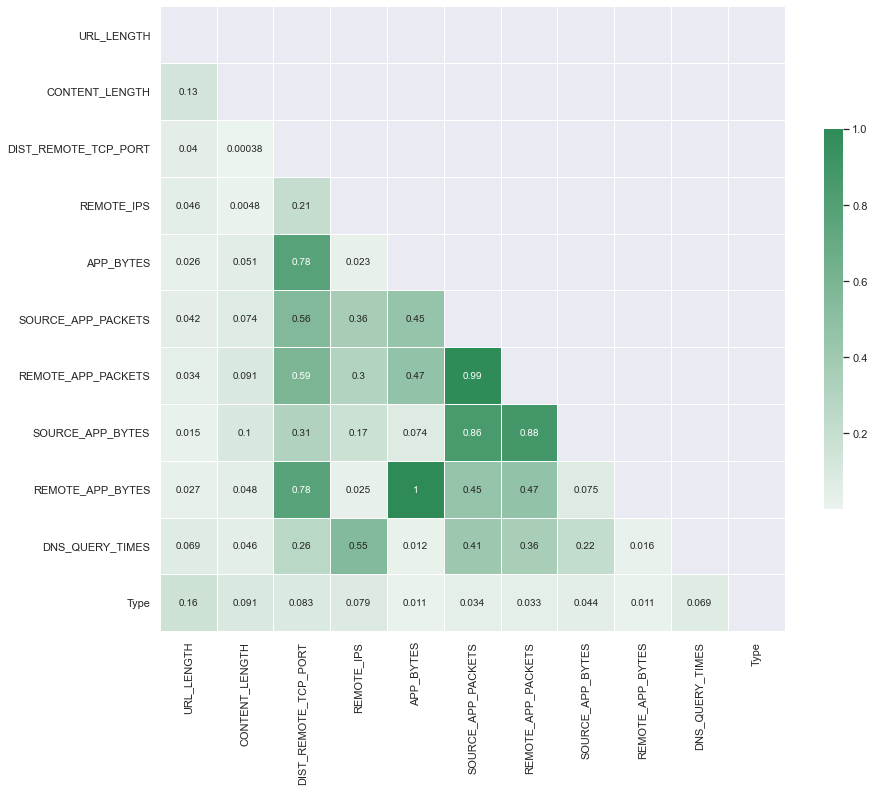

In [709]:
# Print heatmap again
import seaborn as sns
import matplotlib.pyplot as plt

corr=np.abs(websites.corr())

#Set up mask for triangle representation - give only half of the trianlge
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))

# Generate a custom colormap
cmap = sns.light_palette("seagreen", as_cmap=True) 

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap = cmap,vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
plt.show()

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [710]:
# Your code here

websites.isna().sum()


URL                       0
URL_LENGTH                0
CHARSET                   0
SERVER                    1
CONTENT_LENGTH          812
WHOIS_COUNTRY             0
WHOIS_STATEPRO            0
WHOIS_REGDATE             0
WHOIS_UPDATED_DATE        0
DIST_REMOTE_TCP_PORT      0
REMOTE_IPS                0
APP_BYTES                 0
SOURCE_APP_PACKETS        0
REMOTE_APP_PACKETS        0
SOURCE_APP_BYTES          0
REMOTE_APP_BYTES          0
DNS_QUERY_TIMES           1
Type                      0
dtype: int64

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [711]:
# Your code here

#checking proportion of NAs in content lenght column:
websites.isna().sum()["CONTENT_LENGTH"]/websites.shape[0]


0.45592363840539024

In [712]:
# Your comment here:

# almost half of the values from websites["CONTENT_LENGTH"] are missing, thus column should be dropped

websites.drop(columns = ["CONTENT_LENGTH"], inplace = True)

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [713]:
# Examine missing values in each column

websites.isna().sum()

#for the remain columns, the number of missing values are too low to drop the respective columns, hence no more columns will be dropped

#but the rows will have to be dropped as we cannot have NAs for the modelling

websites = websites.dropna()
websites.isna().sum()

URL                     0
URL_LENGTH              0
CHARSET                 0
SERVER                  0
WHOIS_COUNTRY           0
WHOIS_STATEPRO          0
WHOIS_REGDATE           0
WHOIS_UPDATED_DATE      0
DIST_REMOTE_TCP_PORT    0
REMOTE_IPS              0
APP_BYTES               0
SOURCE_APP_PACKETS      0
REMOTE_APP_PACKETS      0
SOURCE_APP_BYTES        0
REMOTE_APP_BYTES        0
DNS_QUERY_TIMES         0
Type                    0
dtype: int64

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [714]:
# Your code here

websites["WHOIS_COUNTRY"].unique()

websites["WHOIS_COUNTRY"] = websites["WHOIS_COUNTRY"].str.replace("Cyprus","CY")
websites["WHOIS_COUNTRY"] = websites["WHOIS_COUNTRY"].str.replace("se","SE")
websites["WHOIS_COUNTRY"] = websites["WHOIS_COUNTRY"].str.replace("us","US")

websites["WHOIS_COUNTRY"] = websites["WHOIS_COUNTRY"].str.replace("United Kingdom","GB") 
websites["WHOIS_COUNTRY"] = websites["WHOIS_COUNTRY"].str.replace("UK","GB")

websites["WHOIS_COUNTRY"] = websites["WHOIS_COUNTRY"].str.replace("\[u'GB'; u'GB'\]","GB")
websites["WHOIS_COUNTRY"].unique()



C:\Users\migue\AppData\Local\Temp\ipykernel_4380\1558156210.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  websites["WHOIS_COUNTRY"] = websites["WHOIS_COUNTRY"].str.replace("\[u'GB'; u'GB'\]","GB")


array(['None', 'US', 'SC', 'GB', 'RU', 'AU', 'CA', 'PA', 'SE', 'IN', 'LU',
       'TH', 'FR', 'NL', 'UG', 'JP', 'CN', 'SI', 'IL', 'ru', 'KY', 'AT',
       'CZ', 'PH', 'BE', 'NO', 'TR', 'LV', 'DE', 'ES', 'BR', 'KR', 'HK',
       'UA', 'CH', 'BS', 'PK', 'IT', 'CY', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

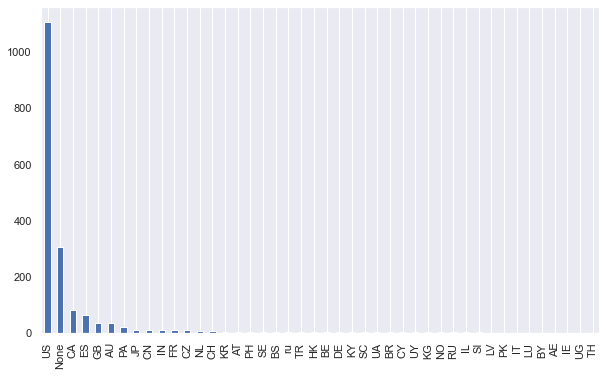

In [715]:
# Your code here

sns.set()
plt.figure(figsize=(10, 6))
websites["WHOIS_COUNTRY"].value_counts().plot(kind="bar")
plt.grid(axis="y")
plt.show()

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [716]:
# Your code here

websites["WHOIS_COUNTRY"].value_counts()[:10].index

#['US', 'None', 'CA', 'ES', 'GB', 'AU', 'PA', 'JP', 'CN', 'IN']

websites.loc[~websites["WHOIS_COUNTRY"].isin(websites["WHOIS_COUNTRY"].value_counts()[:10].index),"WHOIS_COUNTRY"] = "OTHER"

websites["WHOIS_COUNTRY"].unique()

array(['None', 'US', 'OTHER', 'GB', 'AU', 'CA', 'PA', 'IN', 'JP', 'CN',
       'ES'], dtype=object)

In [717]:
#fixing WHOIS_COUNTRY column to numerical

website_country = pd.get_dummies(websites["WHOIS_COUNTRY"])
website_country.drop(columns = ["None"], inplace = True)
website_country

,AU,CA,CN,ES,GB,IN,JP,OTHER,PA,US
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1776,0,0,0,1,0,0,0,0,0,0
1777,0,0,0,1,0,0,0,0,0,0
1778,0,0,0,0,0,0,0,0,0,1
1779,0,0,0,0,0,0,0,0,0,1


Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [718]:
# Your code here
websites.drop(columns = ['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'], inplace = True)

# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [719]:
# Your code here

websites.dtypes

URL                      object
URL_LENGTH                int64
CHARSET                  object
SERVER                   object
WHOIS_COUNTRY            object
DIST_REMOTE_TCP_PORT      int64
REMOTE_IPS                int64
APP_BYTES                 int64
SOURCE_APP_PACKETS        int64
REMOTE_APP_PACKETS        int64
SOURCE_APP_BYTES          int64
REMOTE_APP_BYTES          int64
DNS_QUERY_TIMES         float64
Type                      int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [720]:
# Your code here

websites.drop(columns = ['URL'], inplace = True)

#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [721]:
# Your code here
websites["CHARSET"].unique()

websites["CHARSET"] = [item.upper() for item in websites["CHARSET"]]

websites["CHARSET"].unique()

array(['ISO-8859-1', 'UTF-8', 'US-ASCII', 'NONE', 'WINDOWS-1251',
       'ISO-8859', 'WINDOWS-1252'], dtype=object)

In [722]:
websites_charset = pd.get_dummies(websites["CHARSET"])
websites_charset.drop(columns = ["NONE"], inplace = True)
websites_charset

,ISO-8859,ISO-8859-1,US-ASCII,UTF-8,WINDOWS-1251,WINDOWS-1252
0,0,1,0,0,0,0
1,0,0,0,1,0,0
2,0,0,1,0,0,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
1776,0,0,0,1,0,0
1777,0,0,0,1,0,0
1778,0,0,0,1,0,0
1779,0,1,0,0,0,0


`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [723]:
# Your code here
websites["SERVER"].unique()

array(['nginx', 'Apache/2.4.10', 'Microsoft-HTTPAPI/2.0', 'None',
       'Apache/2', 'nginx/1.10.1', 'Apache', 'Apache/2.2.15 (Red Hat)',
       'Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'openresty/1.11.2.1', 'Apache/2.2.22', 'Apache/2.4.7 (Ubuntu)',
       'nginx/1.12.0',
       'Apache/2.4.12 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'Oracle-iPlanet-Web-Server/7.0', 'cloudflare-nginx', 'nginx/1.6.2',
       'openresty', 'Heptu web server', 'Pepyaka/1.11.3', 'nginx/1.8.0',
       'nginx/1.10.1 + Phusion Passenger 5.0.30',
       'Apache/2.2.29 (Amazon)', 'Microsoft-IIS/7.5', 'LiteSpeed',
       'Apache/2.4.25 (cPanel) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'tsa_c', 'Apache/2.2.0 (Fedora)', 'Apache/2.2.22 (Debian)',
       'Apache/2.2.15 (CentOS)', 'Apache/2.4.25',
       'Apache/2.4.25 (Amazon) PHP/7.0.14', 'GSE',
       'Apache/2.4.23 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Apache/2.4.25 (Amazon) OpenSSL/1.0.1k-fips'

![Think Hard](../images/think-hard.jpg)

In [724]:
# Your comment here

websites["SERVER"] = websites["SERVER"].str.replace(".*Apache.*","Apache")
websites["SERVER"] = websites["SERVER"].str.replace("Microsoft.+","Microsoft")
websites["SERVER"] = websites["SERVER"].str.replace(".ginx.+","nginx")

websites["SERVER"].unique()

# is Tenginx nginx?

C:\Users\migue\AppData\Local\Temp\ipykernel_4380\735049899.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  websites["SERVER"] = websites["SERVER"].str.replace(".*Apache.*","Apache")
C:\Users\migue\AppData\Local\Temp\ipykernel_4380\735049899.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  websites["SERVER"] = websites["SERVER"].str.replace("Microsoft.+","Microsoft")
C:\Users\migue\AppData\Local\Temp\ipykernel_4380\735049899.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  websites["SERVER"] = websites["SERVER"].str.replace(".ginx.+","nginx")


array(['nginx', 'Apache', 'Microsoft', 'None', 'openresty/1.11.2.1',
       'Oracle-iPlanet-Web-Server/7.0', 'cloudflare-nginx', 'openresty',
       'Heptu web server', 'Pepyaka/1.11.3', 'LiteSpeed', 'tsa_c', 'GSE',
       'Tengine', 'Sun-ONE-Web-Server/6.1', 'AmazonS3', 'ATS',
       'CherryPy/3.6.0', 'Server', 'KHL', 'mw2114.codfw.wmnet',
       'Jetty(9.0.z-SNAPSHOT)', 'HTTPDaemon', 'MediaFire', 'DOSarrest',
       'mw2232.codfw.wmnet', 'Sucuri/Cloudproxy', 'mw2260.codfw.wmnet',
       'mw2239.codfw.wmnet', 'DPS/1.1.8', 'ATS/5.3.0', 'SSWS',
       'YouTubeFrontEnd', 'Squeegit/1.2.5 (3_sir)',
       'Virtuoso/07.20.3217 (Linux) i686-generic-linux-glibc212-64  VDB',
       'Yippee-Ki-Yay', 'mw2165.codfw.wmnet', 'mw2192.codfw.wmnet',
       'Proxy Pandeiro UOL', 'mw2231.codfw.wmnet', 'openresty/1.11.2.2',
       'mw2109.codfw.wmnet', 'mw2225.codfw.wmnet', 'mw2236.codfw.wmnet',
       'mw2101.codfw.wmnet', 'Varnish', 'Resin/3.1.8',
       'mw2164.codfw.wmnet', 'mw2242.codfw.wmnet', 'mw2

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [725]:
# Your code here

# server_other = websites[~websites["SERVER"].isin(["Microsoft","Apache","nginx"])]
# server_other

websites.loc[~websites['SERVER'].isin(['Microsoft', 'Apache', 'nginx']), 'SERVER'] = "Other"
websites

,URL_LENGTH,CHARSET,SERVER,WHOIS_COUNTRY,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type
0,16,ISO-8859-1,nginx,None,0,2,700,9,10,1153,832,2.0,1
1,16,UTF-8,Apache,None,7,4,1230,17,19,1265,1230,0.0,0
2,16,US-ASCII,Microsoft,None,0,0,0,0,0,0,0,0.0,0
3,17,ISO-8859-1,nginx,US,22,3,3812,39,37,18784,4380,8.0,0
4,17,UTF-8,Other,US,2,5,4278,61,62,129889,4586,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,194,UTF-8,Apache,ES,0,0,0,0,3,186,0,0.0,1
1777,198,UTF-8,Apache,ES,0,0,0,0,2,124,0,0.0,1
1778,201,UTF-8,Apache,US,2,6,6631,87,89,132181,6945,4.0,0
1779,234,ISO-8859-1,Other,US,0,0,0,0,0,0,0,0.0,0


In [726]:
# Count `SERVER` value counts here

websites["SERVER"].value_counts()
websites["SERVER"].unique()

array(['nginx', 'Apache', 'Microsoft', 'Other'], dtype=object)

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)). Also, assign the data with dummy values to a new variable `website_dummy`.**

In [727]:
# Your code here

website_dummy = pd.get_dummies(websites["SERVER"])

Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [728]:
# Your code here
website_dummy.drop(columns = ["Other"], inplace = True)
website_dummy.head()
#website_dummy.dtypes

,Apache,Microsoft,nginx
0,0,0,1
1,1,0,0
2,0,1,0
3,0,0,1
4,0,0,0


In [729]:
#Concat

websites = pd.concat([websites, website_dummy, websites_charset, website_country], axis=1)
websites.drop(columns = ["CHARSET", "WHOIS_COUNTRY", "SERVER"], inplace = True)
websites.head()

,URL_LENGTH,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type,...,AU,CA,CN,ES,GB,IN,JP,OTHER,PA,US
0,16,0,2,700,9,10,1153,832,2.0,1,...,0,0,0,0,0,0,0,0,0,0
1,16,7,4,1230,17,19,1265,1230,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,17,22,3,3812,39,37,18784,4380,8.0,0,...,0,0,0,0,0,0,0,0,0,1
4,17,2,5,4278,61,62,129889,4586,4.0,0,...,0,0,0,0,0,0,0,0,0,1


In [730]:
websites.head()
websites.dtypes

URL_LENGTH                int64
DIST_REMOTE_TCP_PORT      int64
REMOTE_IPS                int64
APP_BYTES                 int64
SOURCE_APP_PACKETS        int64
REMOTE_APP_PACKETS        int64
SOURCE_APP_BYTES          int64
REMOTE_APP_BYTES          int64
DNS_QUERY_TIMES         float64
Type                      int64
Apache                    uint8
Microsoft                 uint8
nginx                     uint8
ISO-8859                  uint8
ISO-8859-1                uint8
US-ASCII                  uint8
UTF-8                     uint8
WINDOWS-1251              uint8
WINDOWS-1252              uint8
AU                        uint8
CA                        uint8
CN                        uint8
ES                        uint8
GB                        uint8
IN                        uint8
JP                        uint8
OTHER                     uint8
PA                        uint8
US                        uint8
dtype: object

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [731]:
from sklearn.model_selection import train_test_split

features = websites.drop(columns = ["Type"])
labels = websites["Type"]

# Your code here:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=0, test_size=0.20)

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [749]:
# Your code here:

from sklearn.linear_model import LogisticRegression

#initializing model:

log_reg = LogisticRegression(max_iter=10000) #max_iter=10000


Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [750]:
# Your code here:
log_reg.fit(x_train, y_train)
log_reg.fit(x_train, y_train)

LogisticRegression(max_iter=10000)

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [751]:
# Your code here:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = log_reg.predict(x_test)

print(log_reg.score(x_test, y_test))

print(classification_report(y_test, y_pred))

confusion_matrix(y_test, y_pred)

0.9269662921348315
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       317
           1       0.78      0.46      0.58        39

    accuracy                           0.93       356
   macro avg       0.86      0.72      0.77       356
weighted avg       0.92      0.93      0.92       356



array([[312,   5],
       [ 21,  18]], dtype=int64)

What are your thoughts on the performance of the model? Write your conclusions below.

In [735]:
# Your conclusions here:

# The accuracy of the model is high (0.93), but the recall of this model is really bad (0.46)

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [752]:
# Your code here:

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

#train the model:
knn.fit(x_train, y_train)

knn.score(x_test, y_test)


0.9297752808988764

To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [754]:
# Your code here:

pred = knn.predict(x_test)

print(knn.score(x_test, y_test))

print(classification_report(y_test, pred))

confusion_matrix(y_test, pred)


0.9297752808988764
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       317
           1       0.66      0.74      0.70        39

    accuracy                           0.93       356
   macro avg       0.81      0.85      0.83       356
weighted avg       0.93      0.93      0.93       356



array([[302,  15],
       [ 10,  29]], dtype=int64)

#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [755]:
# Your code here:

knn = KNeighborsClassifier(n_neighbors=5)

#train the model:
knn.fit(x_train, y_train)

knn.score(x_test, y_test)

0.9382022471910112

Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [756]:
# Your conclusions here:

pred = knn.predict(x_test)

print(log_reg.score(x_test, y_test))

print(classification_report(y_test, pred))

confusion_matrix(y_test, pred)

# The improvement of accuracy from k=3 to k=5 was very low, and the score for recall actually decreased with k=5.
# Taking into account the points above, the best model for this dataset would likely be a KNeighborsClassifier with k=3

0.9269662921348315
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       317
           1       0.74      0.67      0.70        39

    accuracy                           0.94       356
   macro avg       0.85      0.82      0.83       356
weighted avg       0.94      0.94      0.94       356



array([[308,   9],
       [ 13,  26]], dtype=int64)

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [740]:
# Your code here